# Quora insincere questions
Data and competition info can be found at https://www.kaggle.com/c/quora-insincere-questions-classification.
It is a binary classification task on text data. The competition is judged by f1 score so that is the metric that I shall be trying to optimize.

In [4]:
from functools import partial
from tempfile import mkdtemp

import numpy as np
from scipy.sparse import csr_matrix

import pandas as pd
from IPython.display import display
pd.set_option('display.max_colwidth', -1)

import matplotlib.pyplot as plt
%matplotlib inline

from ecprocessing import text_preprocessing as txp

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

from sklearn.base import BaseEstimator, TransformerMixin

In [5]:
def threshold_search(y_true, y_proba):
    '''Find best threshold to maximize f1 score'''
    best_threshold = 0
    best_score = 0
    for threshold in [i * 0.01 for i in range(51)]:
        score = metrics.f1_score(y_true=y_true, y_pred=y_proba > threshold)
        if score > best_score:
            best_threshold = threshold
            best_score = score
    search_result = {'threshold': best_threshold, 'f1': best_score}
    return search_result

## Importing data

In [7]:
train_raw = pd.read_csv('../../data/train.csv')

In [9]:
train_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1306122 entries, 0 to 1306121
Data columns (total 3 columns):
qid              1306122 non-null object
question_text    1306122 non-null object
target           1306122 non-null int64
dtypes: int64(1), object(2)
memory usage: 29.9+ MB


In [10]:
# Create train test split
X_train, X_test, y_train, y_test = train_test_split(train_raw.question_text, train_raw.target, test_size=0.25, random_state=42, stratify=train_raw.target)

## Preprocessing
Using the ecprocessing package I've created. It's a bit slow to run all the stemming, and horrificly slow to run lemmatization and I've not seen much performance increase from lemmatization so I wouldn't bother. 

In [11]:
text_normalizer_stem = FunctionTransformer(lambda x: x.apply(txp.normalize_text), validate=False)
#normalize_text_lem = partial(txp.normalize_text, text_stemming='Lem')
#text_normalizer_lem = FunctionTransformer(lambda x: x.apply(normalize_text_lem), validate=False)

In [12]:
X_train_norm = text_normalizer_stem.fit_transform(X_train)
X_test_norm = text_normalizer_stem.fit_transform(X_test)

## Modelling

### Count Vectorizer and Logistic Regression

In [13]:
# Pipeline for preprocessing, feature extraction and classification
pl1 = Pipeline([('vectorizer', CountVectorizer(ngram_range=(1, 2), max_df=0.9)),
               ('clf', LogisticRegression())])

In [14]:
%%time
# Fitting the model
pl1.fit(X_train_norm, y_train)

C:\Users\tprjo\AppData\Local\conda\conda\envs\nlphack\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Wall time: 2min 4s


Pipeline(memory=None,
     steps=[('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.9, max_features=None, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
       ...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])

There are 2498091 feature words in the model


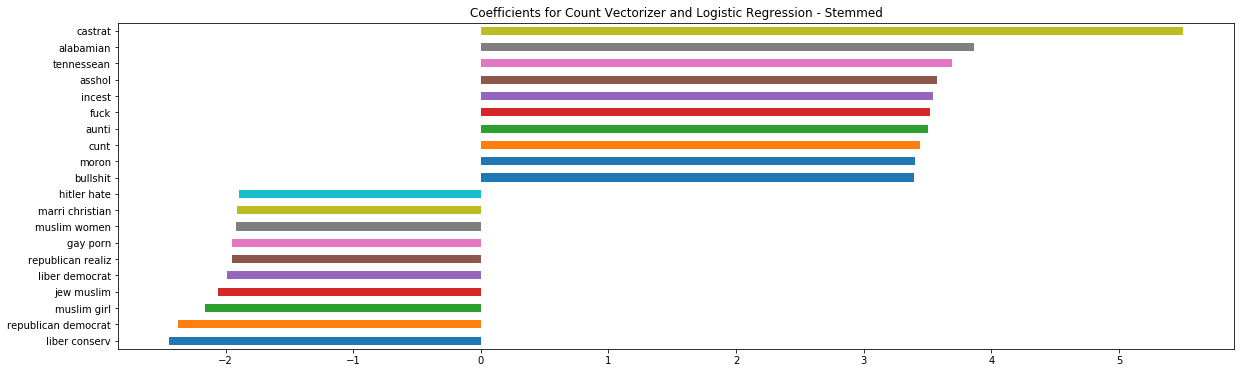

In [15]:
# Plotting most important coefficients
coefs = pd.Series(pl1.named_steps['clf'].coef_[0], index = pl1.named_steps['vectorizer'].get_feature_names())
imp_coefs = pd.concat([coefs.sort_values().head(10), coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh", figsize=(20, 6))
_ = plt.title("Coefficients for Count Vectorizer and Logistic Regression - Stemmed")
print('There are {} feature words in the model'.format(len(coefs)))

In [16]:
# Scoring the model
test_predictions1 = pl1.predict(X_test_norm)
metrics.f1_score(y_test, test_predictions1)

0.5312034078807243

In [17]:
metrics.confusion_matrix(y_test, test_predictions1)

array([[302395,   3933],
       [ 11474,   8729]], dtype=int64)

In [ ]:
# Look at False negatives
pd.DataFrame(X_test[(y_test == 1) & (test_predictions == 0)]).head()

In [ ]:
# Look at False positives
pd.DataFrame(X_test[(y_test == 0) & (test_predictions == 1)]).head()

In [18]:
# Adjust threshold to maximize f1 score
predictions1 = pl1.predict_proba(X_test_norm)
search_result = threshold_search(y_test, predictions1[:,1])
print(search_result)

{'threshold': 0.19, 'f1': 0.6125070422535213}


### Lemmatization with Count Vectorizer and Logistic Regression
Wouldn't reccomend running lemmatization as it is just too slow to preprocess.

In [ ]:
# Pipeline for preprocessing, feature extraction and classification
#pl2 = Pipeline([('normalize_text', text_normalizer_lem),
#               ('vectorizer', CountVectorizer(ngram_range=(1, 2))),
#               ('clf', LogisticRegression())])

In [ ]:
#%%time
# Fitting the model
#pl2.fit(X_train, y_train)

In [ ]:
# Plotting most important coefficients
#coefs = pd.Series(pl2.named_steps['clf'].coef_[0], index = pl2.named_steps['vectorizer'].get_feature_names())
#imp_coefs = pd.concat([coefs.sort_values().head(10), coefs.sort_values().tail(10)])
#imp_coefs.plot(kind = "barh", figsize=(20, 6))
#_ = plt.title("Coefficients for Count Vectorizer and Logistic Regression - Lemmatized")
#print('There are {} feature words in the model'.format(len(coefs)))

In [ ]:
# Scoring the model
#test_predictions2 = pl2.predict(X_test)
#metrics.f1_score(y_test, test_predictions2)

In [ ]:
#metrics.confusion_matrix(y_test, test_predictions2)

## Tfidf
Same as first model but use tfidf instead of count vectorizer.

In [17]:
# Pipeline for preprocessing, feature extraction and classification
pl3 = Pipeline([('vectorizer', TfidfVectorizer(ngram_range=(1, 2), max_df=0.9)),
                ('clf', LogisticRegression())])

In [18]:
%%time
# Fitting the model
pl3.fit(X_train_norm, y_train)

C:\Users\tprjo\AppData\Local\conda\conda\envs\py36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Wall time: 1min 34s


Pipeline(memory=None,
     steps=[('vectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.9, max_features=None, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])

There are 2790864 feature words in the model


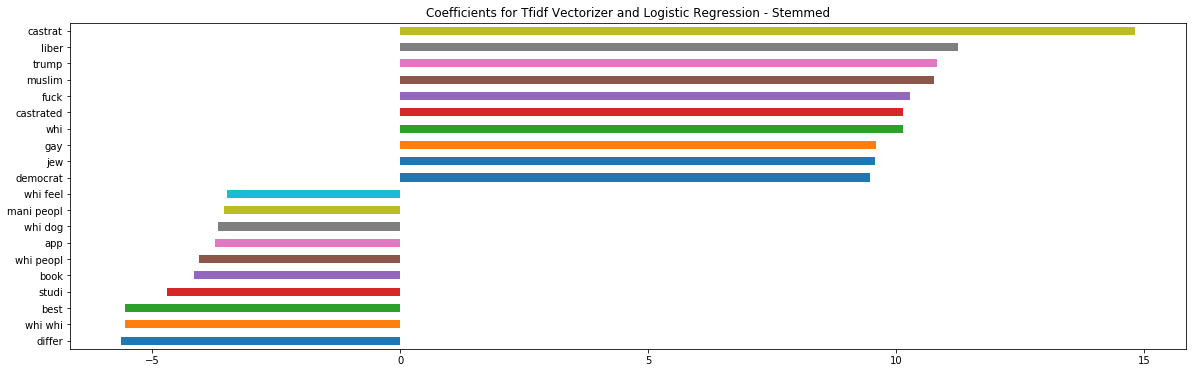

In [19]:
# Plotting most important coefficients
coefs = pd.Series(pl3.named_steps['clf'].coef_[0], index = pl3.named_steps['vectorizer'].get_feature_names())
imp_coefs = pd.concat([coefs.sort_values().head(10), coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh", figsize=(20, 6))
_ = plt.title("Coefficients for Tfidf Vectorizer and Logistic Regression - Stemmed")
print('There are {} feature words in the model'.format(len(coefs)))

In [20]:
# Scoring the model
test_predictions3 = pl3.predict(X_test_norm)
metrics.f1_score(y_test, test_predictions3)

0.5544972948602345

In [21]:
metrics.confusion_matrix(y_test, test_predictions3)

array([[300882,   5446],
       [ 10364,   9839]], dtype=int64)

In [22]:
predictions3 = pl3.predict_proba(X_test_norm)
search_result3 = threshold_search(y_test, predictions3[:,1])
print(search_result3)

{'threshold': 0.31, 'f1': 0.6003026812134354}


## NB-SVM
Following work of Jeremy Howard <a href='https://www.kaggle.com/jhoward/nb-svm-strong-linear-baseline'>kaggle kernel</a>. Details of model <a href='http://www.aclweb.org/anthology/P12-2018'>here</a>. Essentially this transforms the count of each word by multiplying by a log count ratio. You can then run logistic regression after this and it allows the model to deviate from NBs, but only if it is sure as the regularization restricts the deviation. It has been shown to perform very well https://blog.paralleldots.com/data-science/breakthrough-research-papers-and-models-for-sentiment-analysis/.

In [19]:
class NBTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, alpha=1):
        self.r = None
        self.alpha = alpha

    def fit(self, X, y):
        # store smoothed log count ratio
        p = self.alpha + X[y==1].sum(0)
        q = self.alpha + X[y==0].sum(0)
        self.r = csr_matrix(np.log(
            (p / (self.alpha + (y==1).sum())) /
            (q / (self.alpha + (y==0).sum()))
        ))
        return self

    def transform(self, X, y=None):
        return X.multiply(self.r)

In [20]:
%%time
# Preprocess, use Tfidf instead of count vectorizer as it may work ever better
tfidf_vec = TfidfVectorizer(ngram_range=(1,2), max_df=0.9)
X_train_vec = tfidf_vec.fit_transform(X_train_norm)
X_test_vec = tfidf_vec.transform(X_test_norm)

Wall time: 41.3 s


In [21]:
%%time
# Create NB features
nbtransformer = NBTransformer(alpha=1).fit(X_train_vec, y_train.values)
X_train_nb = nbtransformer.transform(X_train_vec)
X_test_nb = nbtransformer.transform(X_test_vec)

Wall time: 5.57 s


In [22]:
%%time
# simple log reg
lr = LogisticRegression(C=2)
lr.fit(X_train_nb, y_train.values)

Wall time: 48.7 s


In [23]:
# Scoring the model
predictions_nbsvm = lr.predict(X_test_nb)
metrics.f1_score(y_test, predictions_nbsvm)

0.5481791352683304

In [24]:
prediction_proba_nbsvm = lr.predict_proba(X_test_nb)
search_result_nbsvm = threshold_search(y_test, prediction_proba_nbsvm[:,1])
print(search_result_nbsvm)

{'threshold': 0.22, 'f1': 0.6009564759564758}


### Hyperparameter tuning
Data leakage in grid search below as TfidfVectorizer and NBTransformer are fit to whole training data.

In [35]:
C = [0.01, 0.03, 0.1, 0.3, 1]
num_folds = 6
hyperparameters = dict(C=C)
clfgs = GridSearchCV(LogisticRegression(), hyperparameters, cv=num_folds, scoring='f1', n_jobs=-1)

In [36]:
%%time
clfgs.fit(X_train_nb, y_train.values)

C:\Users\tprjo\AppData\Local\conda\conda\envs\py36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Wall time: 1h 10min 38s


GridSearchCV(cv=6, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100, 300]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [40]:
print(clfgs.best_score_)
print(clfgs.best_params_)

0.5018010508171881
{'C': 0.1}


In [38]:
best_est = clfgs.best_estimator_
grid_predict = best_est.predict_proba(X_test_nb)
search_result_grid = threshold_search(y_test, grid_predict[:,1])
print(search_result_grid)

{'threshold': 0.17, 'f1': 0.6205894075446041}


There are 2790864 feature words in the model


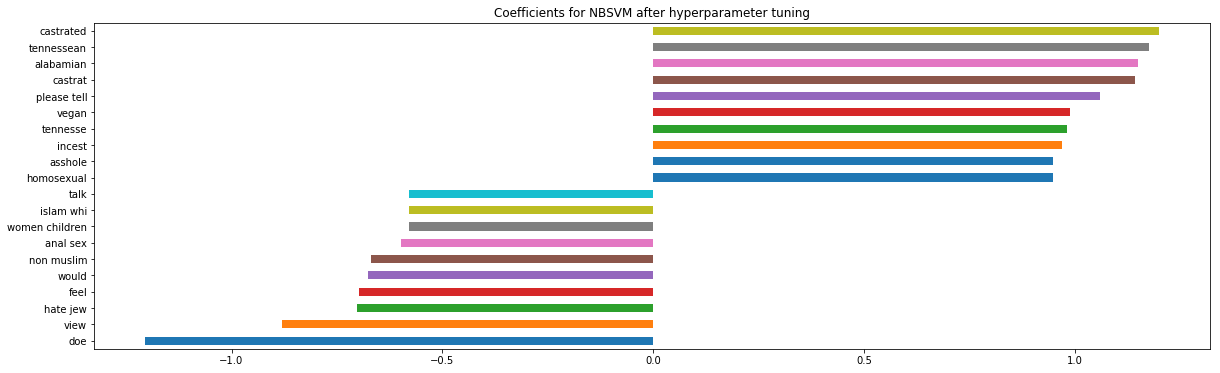

In [39]:
# Plotting most important coefficients
coefs = pd.Series(best_est.coef_[0], index = tfidf_vec.get_feature_names())
imp_coefs = pd.concat([coefs.sort_values().head(10), coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh", figsize=(20, 6))
_ = plt.title("Coefficients for NBSVM after hyperparameter tuning")
print('There are {} feature words in the model'.format(len(coefs)))